## Importing libraries

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import splitfolders
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

2025-12-18 07:43:52.699173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766043832.909849      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766043832.978462      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766043833.500547      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766043833.500593      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766043833.500596      55 computation_placer.cc:177] computation placer alr

## Data Preprocessing

#### **Showing images from each class**

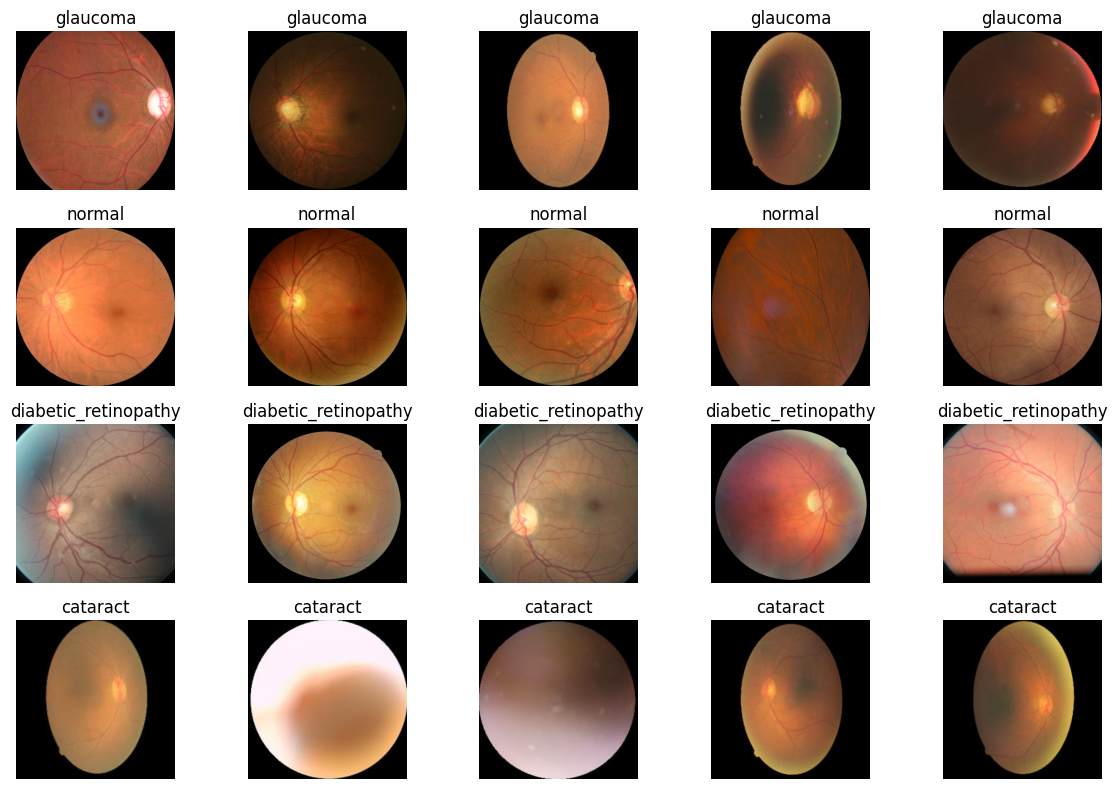

In [3]:
dataset_path = "/kaggle/input/eye-diseases-classification/dataset"
classes = os.listdir(dataset_path)    ## number of classes
samples_per_class = 5                 ##number of images to show from each class

plt.figure(figsize=(12, 8))

img_idx = 1
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)   ##path of each class
    images = os.listdir(cls_path)[:samples_per_class]     ##fetch 5 images form each class

    for img_name in images:
        img_path = os.path.join(cls_path, img_name)       ##gets the path of each image in its class to show
        img = Image.open(img_path)

        plt.subplot(len(classes), samples_per_class, img_idx)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

        img_idx += 1

plt.tight_layout()
plt.show()

#### **Class Distribution**

{'glaucoma': 1007, 'normal': 1074, 'diabetic_retinopathy': 1098, 'cataract': 1038}


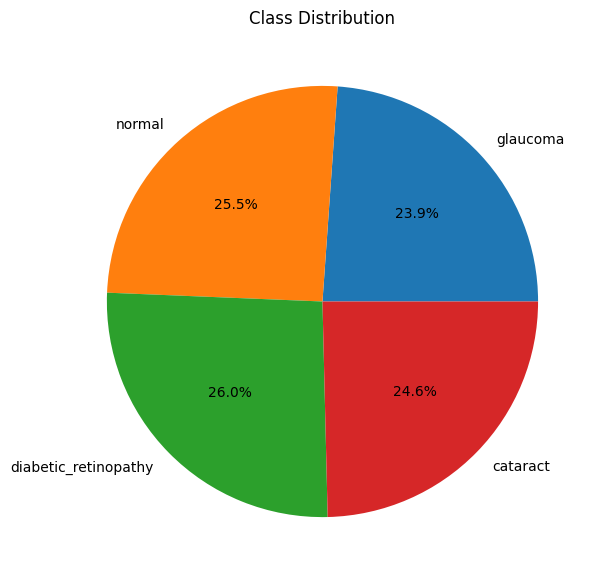

In [4]:
class_counts = {}    ## {class : number of images per class}

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)     ##path of each class
    class_counts[cls] = len(os.listdir(cls_path))  ##count number of images per class

print(class_counts)

classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(7, 7))
plt.pie(
    counts,
    labels=classes,
    autopct='%1.1f%%',
)
plt.title("Class Distribution")
plt.show()

**Almost dataset is balanced**

#### **Data splitting into train, validation, test**

In [5]:
splitfolders.ratio(dataset_path , output = "output_dataset" , seed=1337 , ratio=(0.70,0.15,0.15) , group_prefix=None)

Copying files: 4217 files [00:58, 72.40 files/s] 


In [6]:
train_path = "/kaggle/working/output_dataset/train"
val_path = "/kaggle/working/output_dataset/val"
test_path = "/kaggle/working/output_dataset/test"

In [7]:
def count_images(path):
    total = 0
    class_counts = {}
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            n = len(os.listdir(cls_path))
            class_counts[cls] = n
            total += n
    return total, class_counts

train_total, train_classes = count_images(train_path)
val_total, val_classes     = count_images(val_path)
test_total, test_classes   = count_images(test_path)

print(f"Train set: {train_total} images")
for cls, n in train_classes.items():
    print(f"  {cls}: {n}")

print(f"\nValidation set: {val_total} images")
for cls, n in val_classes.items():
    print(f"  {cls}: {n}")

print(f"\nTest set: {test_total} images")
for cls, n in test_classes.items():
    print(f"  {cls}: {n}")

Train set: 2949 images
  glaucoma: 704
  diabetic_retinopathy: 768
  normal: 751
  cataract: 726

Validation set: 631 images
  glaucoma: 151
  diabetic_retinopathy: 164
  normal: 161
  cataract: 155

Test set: 637 images
  glaucoma: 152
  diabetic_retinopathy: 166
  normal: 162
  cataract: 157


In [8]:
batch_size = 16
Img_height, Img_width = 224, 224
n_classes = 4

#### **Data augmentation on train split only**

In [9]:
##data generatoe on train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.08,
    brightness_range=[0.9, 1.1],
    horizontal_flip=False,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(Img_height, Img_width),
    batch_size=batch_size,
    class_mode='sparse',     
    shuffle=True)

Found 2949 images belonging to 4 classes.


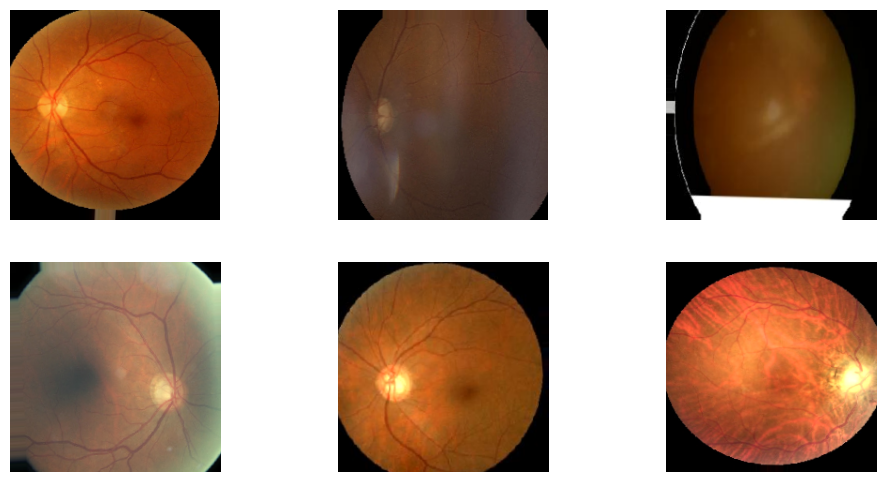

In [10]:
##show augmentation result
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.show()

In [11]:
##data generator on validation set (rescale only)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(Img_height, Img_width),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 631 images belonging to 4 classes.


In [12]:
##data generator on test set (rescale only)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(Img_height, Img_width),
    batch_size=batch_size,
    class_mode='sparse', 
    shuffle=False
)

Found 637 images belonging to 4 classes.


## **Define CNN**

In [13]:
my_model = Sequential()

my_model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=(Img_height, Img_width,3)))
my_model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(2))
my_model.add(Dropout(0.3))

my_model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
my_model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(2))
my_model.add(Dropout(0.3))

my_model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
my_model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))
my_model.add(BatchNormalization())
my_model.add(MaxPooling2D(2))
my_model.add(Dropout(0.4))

my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(n_classes, activation='softmax'))

I0000 00:00:1766043937.007362      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766043937.011328      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
my_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 221, 221, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 9, 9, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 256)      │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,171,012 (8.28 MB)

 Trainable params: 2,170,116 (8.28 MB)

 Non-trainable params: 896 (3.50 KB)

In [15]:
my_model.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7)
]

In [17]:
history = my_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,          
)

Epoch 1/50


I0000 00:00:1766043942.553820     133 service.cc:152] XLA service 0x782928007020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766043942.553870     133 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766043942.553875     133 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766043943.291175     133 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-18 07:45:47.194836: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-18 07:45:47.381357: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/185 ━━━━━━━━━━━━━━━━━━━━ 44:55 15s/step - accuracy: 0.1875 - loss: 4.2309

I0000 00:00:1766043953.849040     133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


153/185 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - accuracy: 0.2747 - loss: 2.4432

2025-12-18 07:46:35.506274: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-18 07:46:35.681524: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


185/185 ━━━━━━━━━━━━━━━━━━━━ 76s 334ms/step - accuracy: 0.2774 - loss: 2.3909 - val_accuracy: 0.2393 - val_loss: 1.4560 - learning_rate: 5.0000e-04
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.3130 - loss: 1.8369 - val_accuracy: 0.3597 - val_loss: 1.3358 - learning_rate: 5.0000e-04
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.3209 - loss: 1.7182 - val_accuracy: 0.3011 - val_loss: 1.7830 - learning_rate: 5.0000e-04
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 52s 282ms/step - accuracy: 0.3555 - loss: 1.5365 - val_accuracy: 0.4390 - val_loss: 1.2252 - learning_rate: 5.0000e-04
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.4243 - loss: 1.2691 - val_accuracy: 0.5357 - val_loss: 1.0694 - learning_rate: 5.0000e-04
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.4669 - loss: 1.1707 - val_accuracy: 0.5103 - val_loss: 1.0652 - learning_rate: 5.0000e-04
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - 

#### **Evaluating Defined CNN**

In [18]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

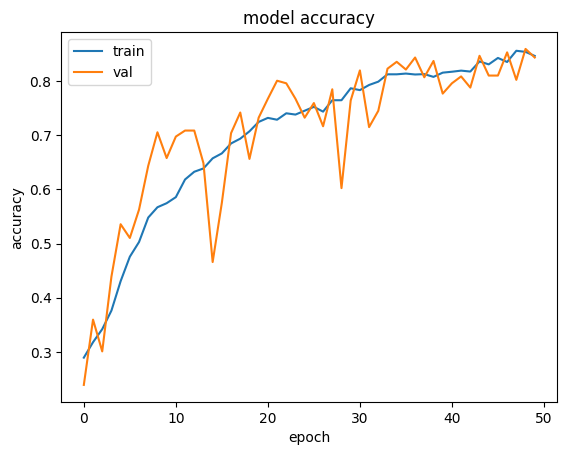

In [19]:
##Plotting model accuracy in train - validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

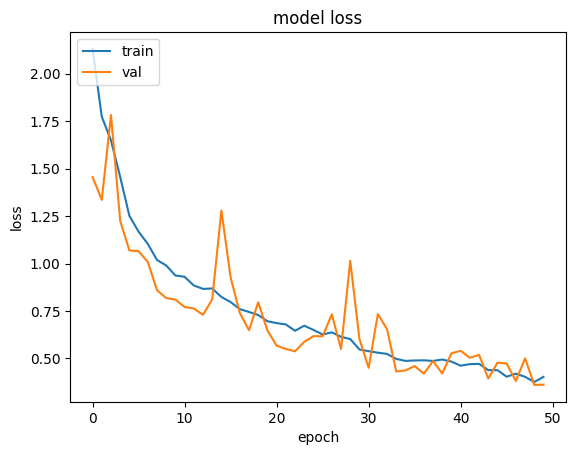

In [20]:
##Plotting model loss in train - test
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [21]:
##calculate test accuracy
test_loss, test_acc = my_model.evaluate(test_generator, steps=len(test_generator))
print('test accuracy:',test_acc )
print('test loss:',test_loss)

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.8824 - loss: 0.2754
test accuracy: 0.8791208863258362
test loss: 0.3171982169151306


In [22]:
y_pred = my_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred , axis=1)
y_true = test_generator.labels      
class_names = ['cataract','diabetic_retinopathy','glaucoma','normal',]

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step


In [23]:
#Classification report
cr = classification_report(y_true , y_pred_classes , target_names=class_names )
print (classification_report(y_true , y_pred_classes , target_names=class_names))

                      precision    recall  f1-score   support

            cataract       0.84      0.89      0.86       157
diabetic_retinopathy       0.99      0.98      0.98       166
            glaucoma       0.89      0.76      0.82       152
              normal       0.81      0.88      0.84       162

            accuracy                           0.88       637
           macro avg       0.88      0.88      0.88       637
        weighted avg       0.88      0.88      0.88       637



In [24]:
##confusion matrix
cm = confusion_matrix(y_true ,y_pred_classes)
print(cm)

[[139   0  10   8]
 [  1 163   0   2]
 [ 13   0 115  24]
 [ 13   2   4 143]]


Text(0.5, 1.0, 'Confusion Matrix')

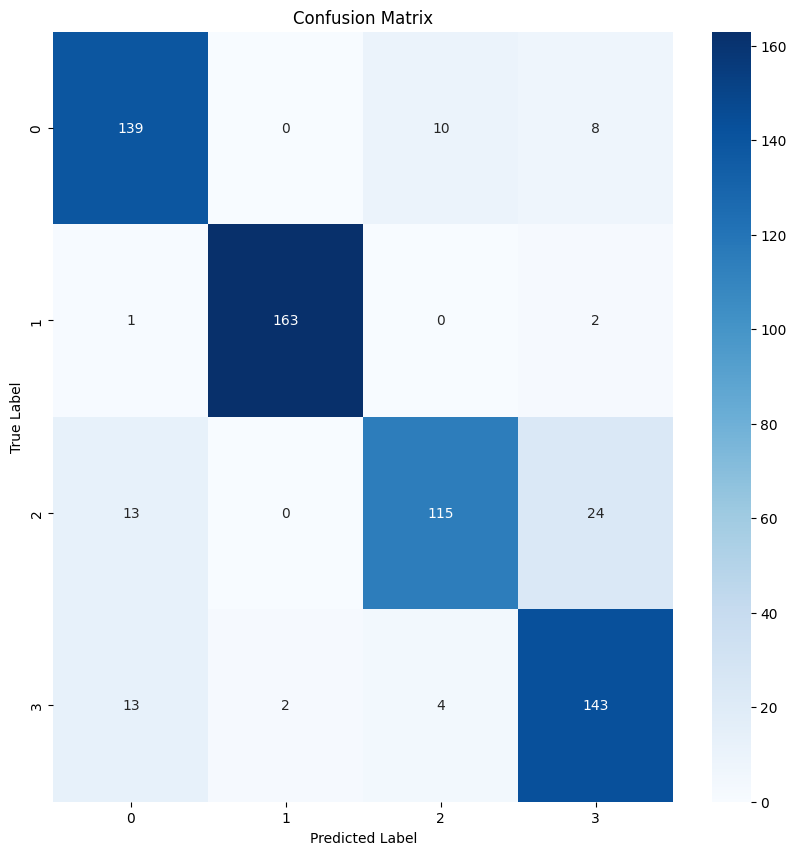

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# Add axis labels and title
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

## **Finetune pretrained model**

In [36]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(Img_height, Img_width, 3),
)
base.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x) 
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(n_classes, activation='softmax')(x)
fine_tuned_model = tf.keras.Model(inputs=base.input, outputs=output)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
fine_tuned_model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,02

 Total params: 14,849,092 (56.64 MB)

 Trainable params: 133,380 (521.02 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [38]:
fine_tuned_model.compile(
    optimizer=Adam(learning_rate=1e-3),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
history_finetuned = fine_tuned_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,          
)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 73s 340ms/step - accuracy: 0.6248 - loss: 0.8933 - val_accuracy: 0.5959 - val_loss: 1.0027 - learning_rate: 0.0010
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 291ms/step - accuracy: 0.7668 - loss: 0.5828 - val_accuracy: 0.8035 - val_loss: 0.6386 - learning_rate: 0.0010
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 53s 284ms/step - accuracy: 0.7926 - loss: 0.5183 - val_accuracy: 0.7623 - val_loss: 0.5839 - learning_rate: 0.0010
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 53s 288ms/step - accuracy: 0.8063 - loss: 0.4866 - val_accuracy: 0.8463 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 53s 286ms/step - accuracy: 0.8364 - loss: 0.4317 - val_accuracy: 0.8526 - val_loss: 0.3868 - learning_rate: 0.0010
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 292ms/step - accuracy: 0.8320 - loss: 0.4222 - val_accuracy: 0.8494 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 289ms/step - accuracy: 0.8

**Evaluating pretrianed model**

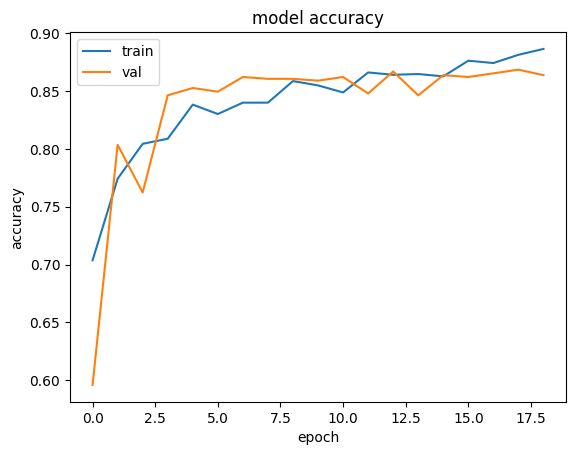

In [41]:
##Plotting model accuracy in train - validation
plt.plot(history_finetuned.history['accuracy'])
plt.plot(history_finetuned.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

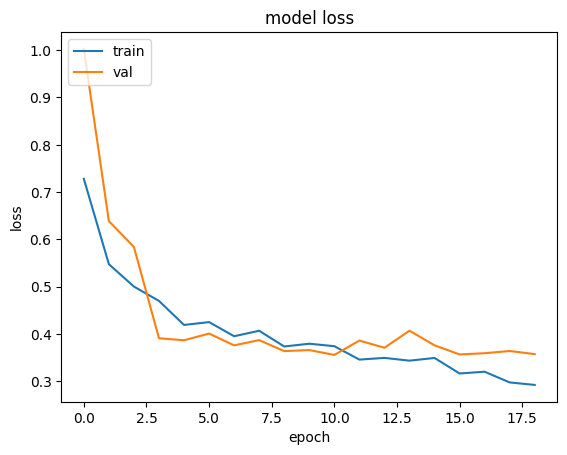

In [42]:
##Plotting model loss in train - test
plt.plot(history_finetuned.history['loss'])
plt.plot(history_finetuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
##calculate test accuracy
test_loss_tuned, test_acc_tuned = fine_tuned_model.evaluate(test_generator, steps=len(test_generator))
print('test accuracy:',test_acc_tuned )
print('test loss:',test_loss_tuned)

40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 332ms/step - accuracy: 0.9238 - loss: 0.2446
test accuracy: 0.901098906993866
test loss: 0.2776082456111908


In [43]:
y_pred_tuned = fine_tuned_model.predict(test_generator)
y_pred_classes_tuned = np.argmax(y_pred_tuned , axis=1)
y_true = test_generator.labels      
class_names = ['cataract','diabetic_retinopathy','glaucoma','normal',]

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step


In [44]:
#Classification report
cr = classification_report(y_true , y_pred_classes_tuned , target_names=class_names )
print (classification_report(y_true , y_pred_classes_tuned , target_names=class_names))

                      precision    recall  f1-score   support

            cataract       0.91      0.92      0.91       157
diabetic_retinopathy       0.99      0.96      0.98       166
            glaucoma       0.88      0.80      0.84       152
              normal       0.83      0.91      0.87       162

            accuracy                           0.90       637
           macro avg       0.90      0.90      0.90       637
        weighted avg       0.90      0.90      0.90       637



In [45]:
##confusion matrix
cm = confusion_matrix(y_true ,y_pred_classes_tuned)
print(cm)

[[145   0  10   2]
 [  1 159   1   5]
 [  7   0 122  23]
 [  7   1   6 148]]


Text(0.5, 1.0, 'Confusion Matrix')

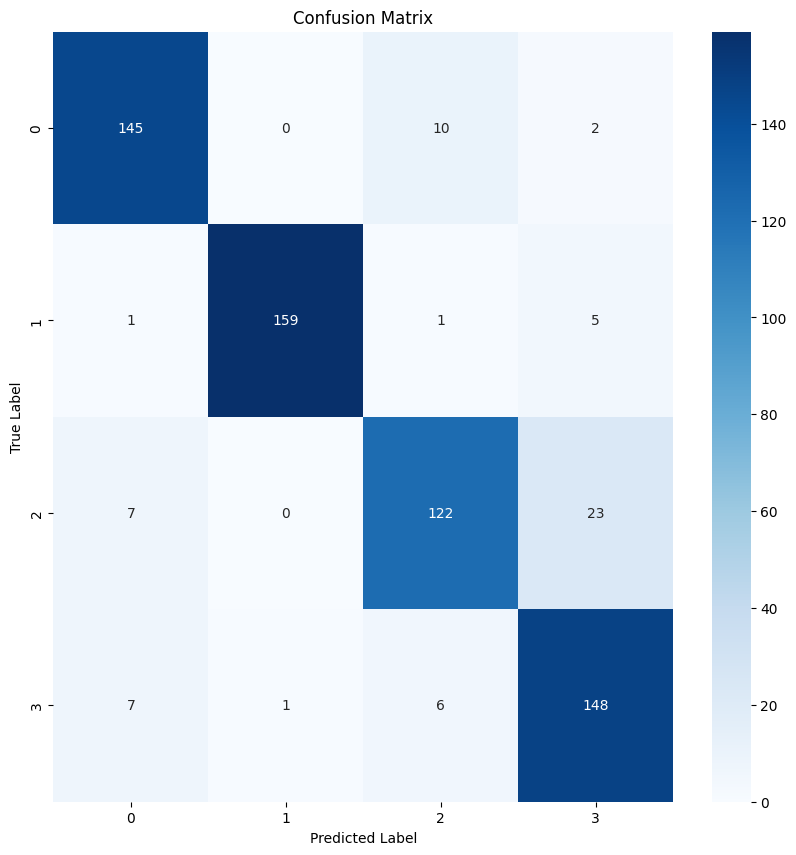

In [46]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# Add axis labels and title
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

## **Another try (Not freezing some layers)**

In [48]:
base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(Img_height, Img_width, 3)
)

base.trainable = True
for layer in base.layers[:-4]:
    layer.trainable = False

x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(n_classes, activation='softmax')(x)

vgg_model = tf.keras.Model(inputs=base.input, outputs=output)

vgg_model.compile(
    optimizer=Adam(learning_rate=5e-5), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = vgg_model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

test_loss, test_acc = vgg_model.evaluate(test_generator)
print("One-stage VGG16 - test accuracy:", test_acc)
print("One-stage VGG16 - test loss:", test_loss)

Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 65s 318ms/step - accuracy: 0.4897 - loss: 1.1804 - val_accuracy: 0.4881 - val_loss: 1.0139 - learning_rate: 5.0000e-05
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 290ms/step - accuracy: 0.7574 - loss: 0.5963 - val_accuracy: 0.7908 - val_loss: 0.5919 - learning_rate: 5.0000e-05
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 55s 294ms/step - accuracy: 0.7969 - loss: 0.5162 - val_accuracy: 0.8320 - val_loss: 0.4422 - learning_rate: 5.0000e-05
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 292ms/step - accuracy: 0.8453 - loss: 0.4296 - val_accuracy: 0.8621 - val_loss: 0.4018 - learning_rate: 5.0000e-05
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 292ms/step - accuracy: 0.8477 - loss: 0.4142 - val_accuracy: 0.8479 - val_loss: 0.4335 - learning_rate: 5.0000e-05
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 292ms/step - accuracy: 0.8735 - loss: 0.3515 - val_accuracy: 0.8304 - val_loss: 0.5551 - learning_rate: 5.0000e-05
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 54s 29

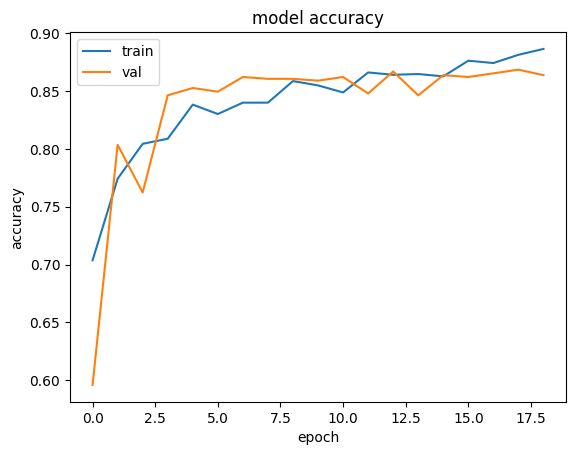

In [49]:
##Plotting model accuracy in train - validation
plt.plot(history_finetuned.history['accuracy'])
plt.plot(history_finetuned.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

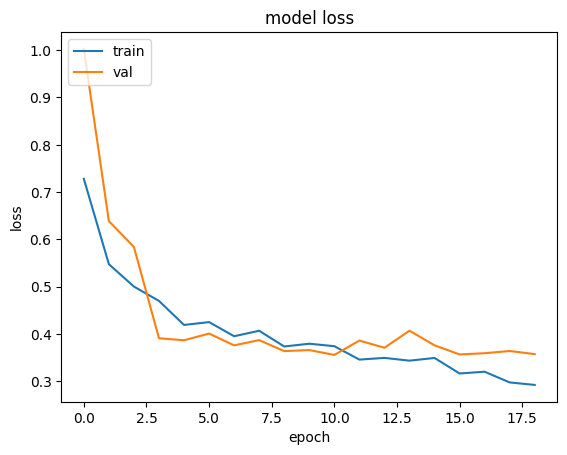

In [50]:
##Plotting model loss in train - test
plt.plot(history_finetuned.history['loss'])
plt.plot(history_finetuned.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
y_pred_tuned2 = vgg_model.predict(test_generator)
y_pred_classes_tuned2 = np.argmax(y_pred_tuned2 , axis=1)
y_true = test_generator.labels      
class_names = ['cataract','diabetic_retinopathy','glaucoma','normal',]

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step


In [52]:
#Classification report
cr = classification_report(y_true , y_pred_classes_tuned2 , target_names=class_names )
print (classification_report(y_true , y_pred_classes_tuned2 , target_names=class_names))

                      precision    recall  f1-score   support

            cataract       0.92      0.94      0.93       157
diabetic_retinopathy       0.99      0.99      0.99       166
            glaucoma       0.91      0.79      0.85       152
              normal       0.83      0.91      0.87       162

            accuracy                           0.91       637
           macro avg       0.91      0.91      0.91       637
        weighted avg       0.91      0.91      0.91       637



In [53]:
##confusion matrix
cm = confusion_matrix(y_true ,y_pred_classes_tuned2)
print(cm)

[[147   0   5   5]
 [  0 165   0   1]
 [  7   0 120  25]
 [  6   1   7 148]]


Text(0.5, 1.0, 'Confusion Matrix')

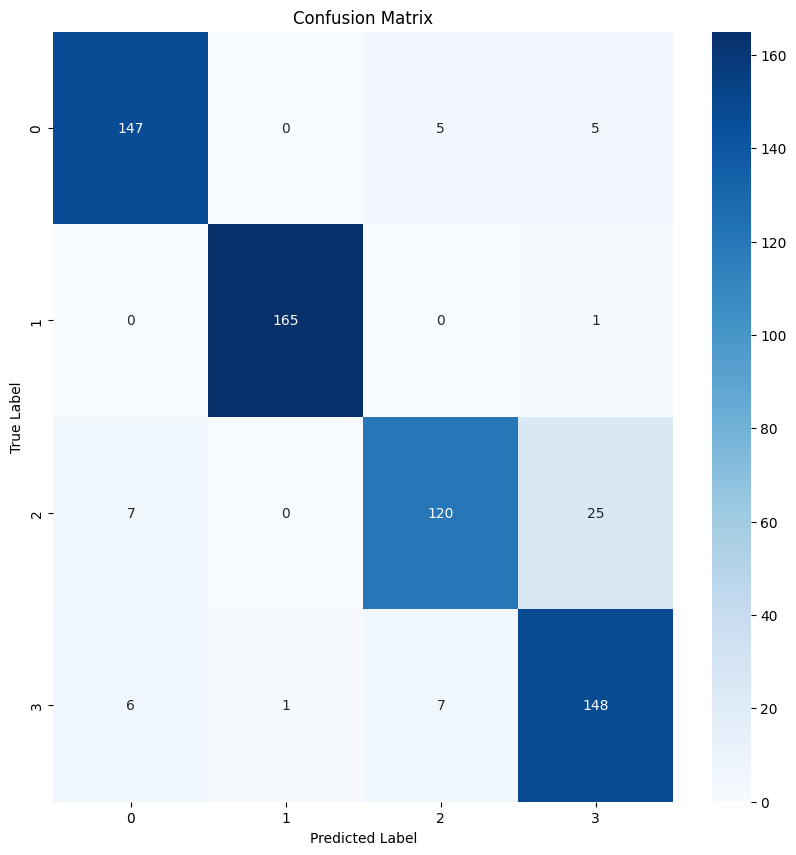

In [56]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)

# Add axis labels and title
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')

## Best model is fine tuned **VGG16 model** with unfreezed layers 

## **Notebook summary** <br>
**1. Dataset visualization** <br>
**2. Data preprocessing** <br>
**3. Custum CNN with train accuracy =85% and test accuracy =87%** <br>
**4. Fintune VGG16 (freezed) with train accuracy =88% and test accuracy =90%** <br>
**3. Fintune VGG16 (unfreezed 4 layers) with train accuracy =94% and test accuracy =91%**